# **TP 2 : Computational Statistics**

__Abel Verley__

## **Exercice 1 :**

> **Question 1 :** On applique la méthode d'inversion de la fonction de répartition. Pour simplifier légèrement les notations, on assimile l'ensemble $\{v_1, \dots, v_n\}$ à $\{1, \dots, n\}$. On a alors l'expression suivante pour le pseudo-inverse de la fonction de répartition de $(\pi_k)_{k = 1 \dots K}$, pour $x \in [0,1]$:
\begin{align}
    F^{-1}(x) = \inf\left\{i \mid  x \le \sum_{k=1}^{i}\pi_k \right\}
\end{align}
Il s'agit alors d'échantillonner $U \sim \mathcal{U}([0,1])$ et de calculer $F^{-1}(U)$. 

>**Question 2 :** 

In [234]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.stats import multivariate_normal, norm
from jax.scipy.special import gammaln
import matplotlib.pyplot as plt
import pandas as pd

key = jr.PRNGKey(0)

In [235]:
def sample_finite(states : jnp.ndarray, dist : jnp.ndarray, key : jr.PRNGKey) -> jnp.ndarray:
    u = jr.uniform(key)
    cumdist = dist.cumsum()
    idx =  jnp.argmax(u <= cumdist)
    return states[idx]

>**Question 3 :** Pour tester la fonction précédente, on échantillonne une distribution simple sur 5 états possible, puis un affiche l'histogramme. On remarque que les proportions correspondent bien aux probabilités de la distribution.

In [236]:
states = jnp.arange(0, 5)
dist = jnp.array([1., 1., 1., 10. ,1.])
dist = dist/dist.sum()
dist

Array([0.07142857, 0.07142857, 0.07142857, 0.71428573, 0.07142857],      dtype=float32)

In [237]:
N_sample = 10000
key, subkey = jr.split(key)
subkeys = jr.split(subkey, N_sample)

samples = jax.vmap(lambda key : sample_finite(states, dist, key))(subkeys)

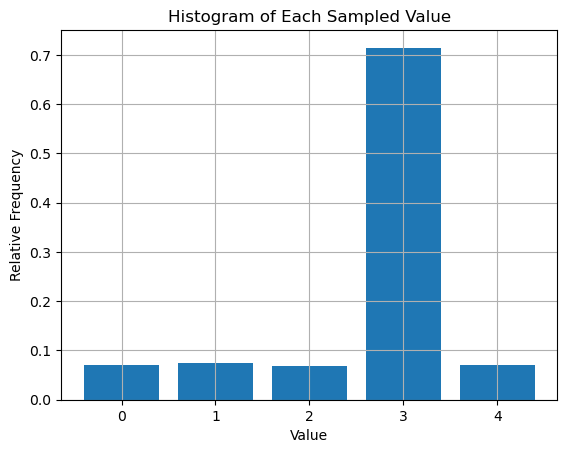

In [238]:
# Plot the histogram for each unique value in samples
unique_values = states
counts = [(samples == val).sum() for val in unique_values]
plt.bar(unique_values, jnp.array(counts) / samples.size, width=0.8, align='center')
plt.xlabel('Value')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Each Sampled Value')
plt.xticks(unique_values)
plt.grid(True)
plt.show()

## **Exercice 2 :**

>**Question 1 :** Les paramètres du modèle GMM sont les probabilité d'apartenance aux classes, et les paramètres des lois gaussiennes associées : 
\begin{equation}
    \theta = (\alpha_1, \dots, \alpha_m, \mu_1, \dots, \mu_m, \Sigma_1, \dots, \Sigma_m) \in ]0,1[^m \times (\mathbb{R}^d)^m \times S_d^{++}(\mathbb{R})^m
\end{equation} 
Par la suite, notons $\Theta$ l'ensemble de droite. La vraissemblance d'un échantillon se calcule par la formule des probabilités toales :
\begin{align}
    f_\theta(x) &= \sum_{j=1}^m p_\theta(x | Z=j)\mathbb{P}_\theta(Z = j) \\
                &= \sum_{j=1}^m \alpha_j \mathcal{N}(x | \mu_j, \Sigma_j)
\end{align}
où $\mathcal{N}(x | \mu, \Sigma)$ désigne la densité de la loi normale $\mathcal{N}(\mu, \Sigma)$. La vraissemblence du modèle s'écrit donc 
\begin{equation}
    \mathcal{L}(x_1, \dots, x_n; \theta) = \prod_{i=1}^n\sum_{j=1}^m \alpha_j \mathcal{N}(x_i| \mu_j, \Sigma_j)
\end{equation}

>**Question 2 :**

In [239]:
def sample_GMM(alphas, means, covs, key):
    key1, key2 = jr.split(key)
    m = len(alphas)
    idx = sample_finite(jnp.arange(0,m), alphas, key1)
    mean, cov = means[idx], covs[idx]
    return jr.multivariate_normal(key2, mean, cov)

In [240]:
def log_likelihood(xs, alphas, means, covs):
    # For numerical stability use use log exp tricks
    log_alphas = jnp.log(alphas) 
    log_probs = jax.vmap(
        lambda x: jax.vmap(
            lambda log_alpha, mu, Sigma: log_alpha + multivariate_normal.logpdf(x, mu, Sigma)
        )(log_alphas, means, covs)
    )(xs)  
    log_likelihood_per_point = jax.scipy.special.logsumexp(log_probs, axis=1) 
    ll = jnp.sum(log_likelihood_per_point)
    
    return ll

In [241]:
N_sample = 1000

alphas = jnp.array([0.2, 0.3, 0.5])

means = jnp.array([
    [-3.0,  0.0],   
    [ 0.0,  4.0],   
    [ 4.0, -3.0],   
])

covs = jnp.array([
    [
        [0.2, 0.0],
        [0.0, 0.2]
    ],
    [
        [0.3, 0.05],
        [0.05, 0.3]
    ],
    [
        [0.25, 0.0],
        [0.0,  0.4]
    ],
])

theta_gt = {"alphas" : alphas, "means": means, "covs": covs}



In [242]:
key, subkey = jr.split(key)
subkeys = jr.split(subkey, N_sample)

xs = jax.vmap(lambda key : sample_GMM(alphas, means, covs, key))(subkeys)
ll_gt = log_likelihood(xs, alphas, means, covs)

In [243]:
def plot_gmm(xs, alphas, means, covs, *, title=None, xlabel="x1", ylabel="x2", xlim=None, ylim=None, alpha = 0.5, s = 10, vmin=None, vmax=None):
    """ 
    Function to plot clusters with estimated log-likelihood
    """
    
    m = len(alphas)  # number of clusters

    plt.figure(figsize=(8, 8))

    # Determine plot range
    if xlim is None:
        x_min, x_max = xs[:, 0].min(), xs[:, 0].max()
        x_range = x_max - x_min
        xlim = (x_min - 0.1 * x_range, x_max + 0.1 * x_range)

    if ylim is None:
        y_min, y_max = xs[:, 1].min(), xs[:, 1].max()
        y_range = y_max - y_min
        ylim = (y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Create grid for contour plot
    x = jnp.linspace(xlim[0], xlim[1], 200)
    y = jnp.linspace(ylim[0], ylim[1], 200)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))

    density_vectorized = jax.vmap(jax.vmap(
        lambda x: jnp.sum(jax.vmap(
            lambda alpha, mean, cov: alpha * multivariate_normal.pdf(x, mean, cov)
        )(alphas, means, covs))
    ))
    
    # Plot the likelihood in the background
    Z = density_vectorized(pos)
    log_Z = jnp.log(Z + 1e-10)  # Add small epsilon to avoid log(0)
    
    # Clip values to reduce contrast
    if vmin is None:
        vmin = jnp.percentile(log_Z, 5)  # Use 5th percentile instead of min
    if vmax is None:
        vmax = log_Z.max()
    
    plt.contourf(X, Y, jnp.clip(log_Z, vmin, vmax), levels=20, cmap='viridis')

    # Plot the means
    for j in range(m):
        # Plot mean as black dot
        plt.scatter(means[j, 0], means[j, 1], c='black', s=100, marker='x', zorder=5)

    # Plot data points on top
    plt.scatter(xs[:, 0], xs[:, 1], s=s, c="red", alpha =alpha, linewidths=0.5)

    # Set labels and title
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if title:
        plt.title(title, fontsize=14)

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.grid(True)
    plt.show()

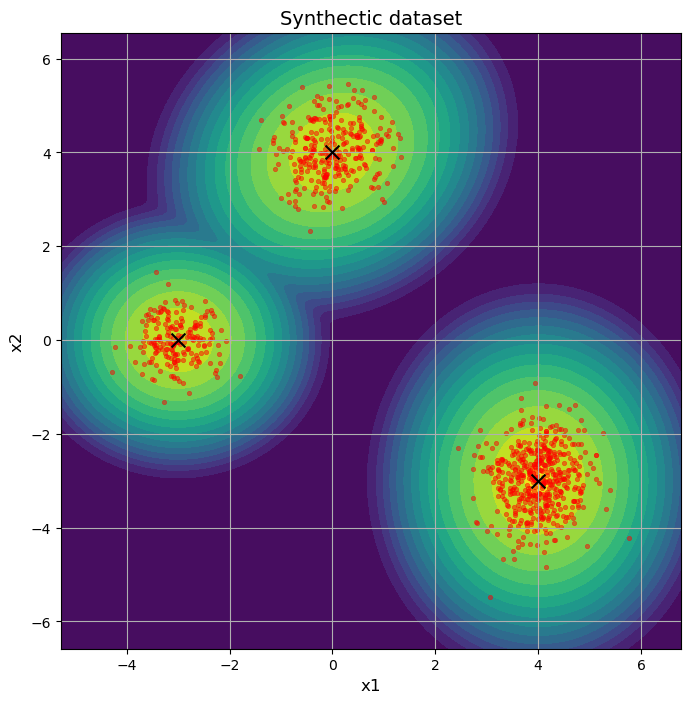

In [244]:
plot_gmm(xs, alphas, means, covs, title = "Synthectic dataset")

>**Question 3 :** L'algorithme EM construit itérativement l'estimation du paramètre $\theta$ par la règle suivante :
\begin{equation}
    \begin{cases}
        Q(\theta, \theta^n) = \sum_{i = 1}^n\mathbb{E}_{Z_i \sim p_{\theta^n}(\cdot |x_i)}[\log p_{\theta}(x_i,Z_i)] \\
        \theta^{n+1} \in \arg\max_{\theta\in \Theta} Q(\theta, \theta^n)
    \end{cases}
\end{equation}
Pour exprimer la phase "expectation" de l'algorithme EM, on commence par calculer la log-vraissemblance complète : 
\begin{align}
    \log(p_\theta(X,Z)) &= \log(p_\theta(X|Z)) + \log(p_\theta(Z))\\
                    &= \sum_{j = 1}^m 1\!\!1_{Z = j}\left[\log(\mathcal{N}(X| \mu_j, \Sigma_j)) + \log(\alpha_j)\right] \\
                    &= \sum_{j = 1}^m 1\!\!1_{Z = j}\left[\log(\alpha_j)-\frac{1}{2}(X - \mu_j)^T\Sigma_j^{-1}(X-\mu_j) - \frac{d}{2}\log(2\pi) - \frac{1}{2}\log(|det \Sigma_j|)\right] \\
\end{align}
Par ailleurs, on a on peut calculer la distribution posterieure $\pi(j,x, \theta) \triangleq \mathbb P_\theta(Z=j |X = x)$ par le théorème de Bayes: 
\begin{align}
    \mathbb P_\theta(Z = j | X = x) &= \frac{p_\theta(x|Z=j)\mathbb{P}_\theta(Z=j)}{f_\theta(x)} \\
                            &=  \frac{\alpha_j \mathcal{N}(x | \mu_j, \Sigma_j)}{\sum_{k = 1}^m \alpha_k \mathcal{N}(x | \mu_k, \Sigma_k)}
\end{align}
Par linéarité de l'espérence on peut maintenant calculer la fonction $Q(\theta, \theta^n)$ : 
\begin{align}
    Q(\theta, \theta^n) &= \sum_{i = 1}^n \sum_{j = 1}^m \mathbb{E}_{\theta^n}[1\!\!1_{Z = j}|X_i = x_i]\left[\log(\alpha_j)-\frac{1}{2}(x_i - \mu_j)^T\Sigma_j^{-1}(x_i-\mu_j) - \frac{d}{2}\log(2\pi) - \frac{1}{2}\log(|det \Sigma_j|)\right] \\ 
    &= \sum_{i=1}^n\sum_{j=1}^m \pi(j,x_i,\theta^n)\left[\log(\alpha_j) - \frac{1}{2}\left[(x_i - \mu_j)^T\Sigma_j^{-1}(x_i-\mu_j) +\log(|det \Sigma_j|)\right]\right]-\frac{nd}{2}\log(2\pi)
\end{align}
Quant à la phase de "maximization" de l'algorithme EM, on doit résoudre le problème d'optimisation $\theta^{n+1}\in \arg \max_{\theta \in \Theta } Q(\theta, \theta^n)$ sous contrainte d'égalité linéaire $\sum_{j=1}^m\alpha_j = 1$. Notons que, en tant que produit d'ouverts convexes, $\Theta = ]0,1[^m \times (\mathbb{R}^d)^m \times S_d^{++}(\mathbb{R})^m$ est aussi un ouvert convexe. On peut, par ailleurs, montrer que $Q(\theta, \theta^n)$ est une fonction concave. On est dans le cadre d'un problème d'optimisation convexe qui se résoud en introduisant le Lagrangien suivant, dont on cherche à annuler le gradient
\begin{equation}
    \mathcal{L}(\theta, \lambda) = -Q(\theta, \theta^n) + \lambda\left( \sum_{j =1}^m \alpha_j -1\right)
\end{equation}
On a directement l'expression suivante pour les dérivées partielles selon les $\alpha_j$:
\begin{equation}
    \frac{\partial \mathcal{L}}{\partial \alpha_j}(\theta, \lambda) = -\frac{1}{\alpha_j}\sum_{i= 1}^n \pi(j, x_i, \theta^n) +\lambda
\end{equation}
La condition $\frac{\partial \mathcal{L}}{\partial \alpha_j}(\theta, \lambda) = 0$ implique donc que $\alpha_j = \frac{1}{\lambda}\sum_{i=1}^n\pi(j,x_i, \theta^n)$. Mais de surcroît, $\frac{\partial \mathcal{L}}{\partial \lambda} (\theta, \lambda) = \sum_{j = 1}^m \alpha_j -1 = 0$, on a : 
\begin{equation}
    \lambda = \sum_{i = 1}^n\sum_{j = 1}^m \pi(j, x_i, \theta^n ) = n
\end{equation} 
Ainsi : 
\begin{equation}
    \alpha_j = \frac{1}{n}\sum_{i= 1}^n \pi(j, x_i, \theta^n)
\end{equation}
Par ailleurs, pour une matrice symétrique $\Sigma$, le gradient de $\mu \mapsto (x-\mu)^T\Sigma(x-\mu)$ vaut $-2\Sigma(x-\mu)$. On en déduit que :  
\begin{equation}
    \nabla_{\mu_j} \mathcal{L}(\theta, \lambda) = \sum_{i=1}^n \pi(j,x_i,\theta^n)\Sigma_j^{-1}(x_i-\mu_j)
\end{equation}
et donc la condition $ \nabla_{\mu_j} \mathcal{L}(\theta, \lambda) = 0$ équivaut à :
\begin{equation}
    \mu_j = \frac{1}{\sum_{i=1}^n\pi(j,x_i,\theta^n)}\sum_{i=1}^n\pi(j,x_i,\theta^n)x_i
\end{equation} 
Enfin, d'une part $\Sigma \mapsto (x-\mu)^T\Sigma^{-1}(x-\mu)$ a pour gradient $-\Sigma^{-1}(x-\mu)(x-\mu)^T\Sigma^{-1}$ et d'autre part, $\Sigma \mapsto \log(\det(\Sigma))$ a pour gradient $\Sigma^{-1}$ (formule de Jacobi). On a donc : 
\begin{equation}
    \nabla_{\Sigma_j}\mathcal{L}(\theta, \lambda) = \sum_{i=1}^n\pi(j,x_i, \theta^n)\left[\Sigma_j^{-1}-\Sigma_j^{-1}(x_i-\mu_j)(x_i-\mu_j)^T\Sigma_j^{-1}\right]
\end{equation}
et donc la condition $ \nabla_{\Sigma_j} \mathcal{L}(\theta, \lambda) = 0$ équivaut à :
\begin{equation}
    \Sigma_j = \frac{1}{\sum_{i=1}^n\pi(j,x_i, \theta^n)}\sum_{i=1}^n\pi(j,x_i, \theta^n)(x_i-\mu_j)(x_i-\mu_j)^T
\end{equation}
En conclusion $Q(\theta, \theta^n)$ admet un maximum qui est donné par les règles mise à jour des paramètres suivantes qu'on peut itérer pour constituer l'algorithme EM : 
\begin{align}
    &\alpha_j^{n+1} \gets \frac{1}{n}\sum_{i= 1}^n \pi(j, x_i, \theta^n) \\
    &\mu_j^{n+1} \gets \frac{1}{\sum_{i=1}^n\pi(j,x_i,\theta^n)}\sum_{i=1}^n\pi(j,x_i,\theta^n)x_i \\
    &\Sigma_j^{n+1} \gets \frac{1}{\sum_{i=1}^n\pi(j,x_i, \theta^n)}\sum_{i=1}^n\pi(j,x_i, \theta^n)(x_i-\mu_j^{n+1})(x_i-\mu_j^{n+1})^T \\
\end{align}

>Dans la suite, on implémente l'algorithme EM et on le teste sur notre jeu de données synthétique. On remarque qu'il est important d'imposer une condition initiale non symétrique par permutation de l'indice $j$, sinon les mises à jour des paramètres restent indépendants de $j$.

In [245]:
def em_GMM(xs, alphas_0, means_0, covs_0, n_iter):
    
    n = xs.shape[0]

    # Auxiliary function that computes one step of the EM algorithm
    def em_step(carry, x):
        # Get carry
        alphas = carry["alphas"]
        means = carry["means"]
        covs = carry["covs"]
        
        # Compute \pi(j, x_i, \theta^n) with the formula above
        # For numerical stability we use log-exp trick
        log_alphas = jnp.log(alphas)
        log_probs = jax.vmap(
            lambda x: jax.vmap(
                lambda log_alpha, mu, Sigma: log_alpha + multivariate_normal.logpdf(x, mu, Sigma)
            )(log_alphas, means, covs)
        )(xs)
        log_norm = jax.scipy.special.logsumexp(log_probs, axis=1, keepdims=True)  # Shape: (n, 1)
        log_pi = log_probs - log_norm  
        pi = jnp.exp(log_pi)  


        # Update \theta
        alphas = jnp.sum(pi, axis = 0)/n
        means = 1/(n*alphas)[:,None]*jnp.dot(pi.T, xs)
        x_minus_mu = xs[:, None, :] - means[None, :, : ]
        right_member = x_minus_mu[:, :, :, None]@x_minus_mu[:, :, None, :]
        covs = 1/(n*alphas)[:, None, None]*jnp.einsum('ij, ijkl -> jkl', pi, right_member)

        #Update the carry
        carry["alphas"] = alphas
        carry["means"] = means
        carry["covs"] = covs

        # Compute log-likelyhood
        ll = log_likelihood(xs, alphas, means, covs)

        return carry, ll

    init = {"alphas": alphas_0, "means" : means_0, "covs" : covs_0}
    theta, lls = jax.lax.scan(em_step, init, jnp.zeros(n_iter)) # iterate the auxiliary step function
    
    return theta, lls

In [246]:
n_iter = 100

# Initialisation at random with identity covs : 
key, subkey = jr.split(key)
subkey1, subkey2 = jr.split(subkey, 2)

alphas_0 = jr.uniform(subkey1, shape = (3,))
alphas_0 = alphas_0/jnp.sum(alphas_0)
means_0 = jr.uniform(subkey2, shape = (3,2))
covs_0 = jnp.array([jnp.eye(2)] * 3)


theta_init = {"alphas": alphas_0, "means": means_0, "covs": covs_0}
ll_init = log_likelihood(xs, alphas_0, means_0, covs_0)

theta, lls = em_GMM(xs, alphas_0, means_0, covs_0, n_iter)

=== Log-likelihood Comparison : === 

Initial log-likelihood : -10805.1328125
Final log-likelihood : -2616.690673828125
Ground truth log-likelihood : -2622.34033203125 

=== Parameters Comparison : === 

Estimated alphas : [0.19800001 0.503      0.29900002]
Ground truth alphas : [0.2 0.3 0.5]



Estimated means : [[-3.0395982e+00 -1.2103796e-03]
 [ 3.9978426e+00 -2.9679620e+00]
 [-6.7751813e-03  4.0443497e+00]]
Ground truth means : [[-3.  0.]
 [ 0.  4.]
 [ 4. -3.]]



Estimated covariances : [[[ 0.17912892 -0.00224615]
  [-0.00224615  0.20191026]]

 [[ 0.24138445  0.01725159]
  [ 0.01725159  0.42154095]]

 [[ 0.30517128  0.03947706]
  [ 0.03947706  0.33252692]]]
Ground truth covariances : [[[0.2  0.  ]
  [0.   0.2 ]]

 [[0.3  0.05]
  [0.05 0.3 ]]

 [[0.25 0.  ]
  [0.   0.4 ]]]


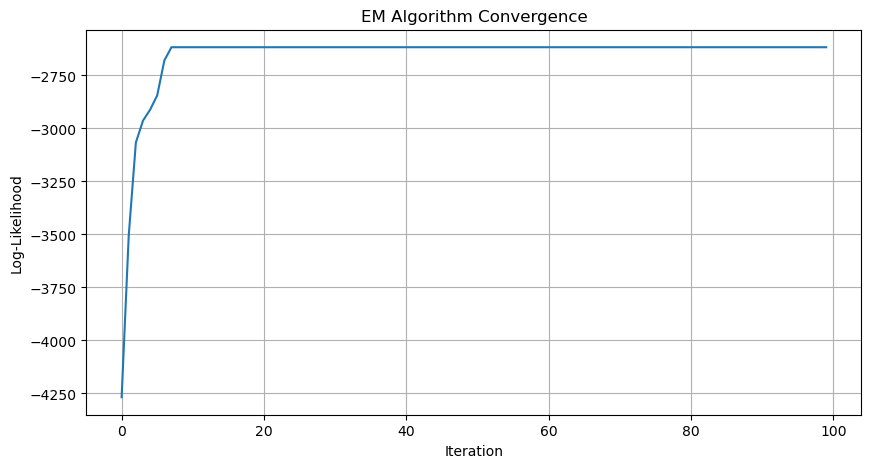

In [247]:
print("=== Log-likelihood Comparison : === \n")
print(f"Initial log-likelihood : {ll_init}")
print(f"Final log-likelihood : {lls[-1]}")
print(f"Ground truth log-likelihood : {ll_gt} ")

print("\n=== Parameters Comparison : === \n")
print(f"Estimated alphas : {theta["alphas"]}")
print(f"Ground truth alphas : {theta_gt["alphas"]}")
print("\n\n")

print(f"Estimated means : {theta["means"]}")
print(f"Ground truth means : {theta_gt["means"]}")
print("\n\n")

print(f"Estimated covariances : {theta["covs"]}")
print(f"Ground truth covariances : {theta_gt["covs"]}")

plt.figure(figsize=(10, 5))
plt.plot(lls)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

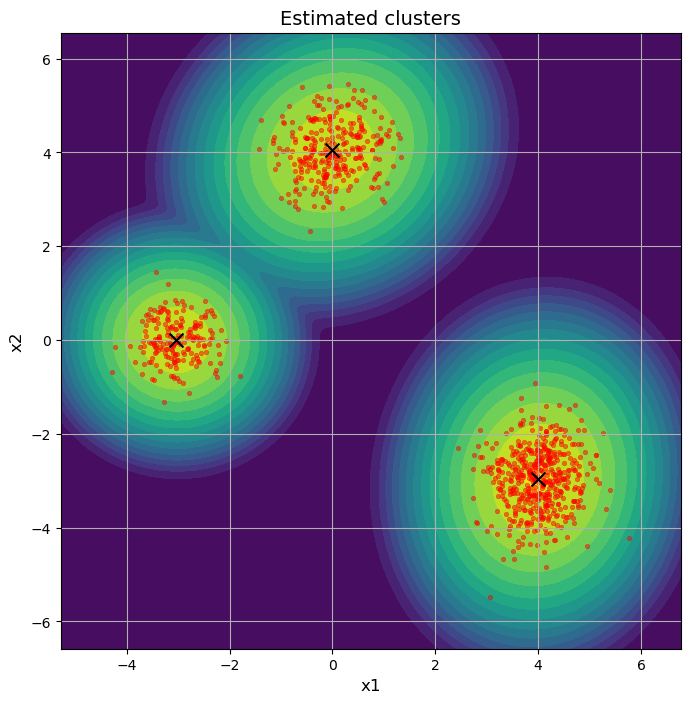

In [248]:
plot_gmm(xs, theta["alphas"], theta["means"], theta["covs"], title = "Estimated clusters")

> **Question 4 :** On remarque qu'après une dizaine d'itérations l'algorithme atteint une valeur stationnaire. A permutation près des indices de cluster, les valeurs estimées semblent proches des valeurs "ground truth". On calcule la MSE pour avoir une estimation plus quantitative de notre précision. 

In [249]:
# Permute rows: 
perm_idx = jnp.array([0, 2, 1])
theta_permuted = {
    "alphas": theta["alphas"][perm_idx],
    "means": theta["means"][perm_idx],
    "covs": theta["covs"][perm_idx]
}

err_alphas = jnp.linalg.norm(alphas - theta_permuted["alphas"])
err_means = jnp.linalg.norm(means - theta_permuted["means"])
err_covs = jnp.linalg.norm(covs - theta_permuted["covs"])

print(f"MSE alphas : {err_alphas}")
print(f"MSE means : {err_means}")
print(f"MSE covs : {err_covs}")

MSE alphas : 0.003741665044799447
MSE means : 0.06792177259922028
MSE covs : 0.05374963581562042


>**Question 5 :** On importe les données et on les affiche. Le seul prétraitement appliqué consiste à retirer les lignes contenant des valeurs manquantes. On s'apperçoit que les points ne sembles pas se dsitribuer selon une mixture de gaussiennes mais plutôt selon une distribution "banane".

In [250]:
xs_data_pd = pd.read_csv("data.csv")[["CBR", "CDR"]].dropna()
xs_data = jnp.array(xs_data_pd)

/var/folders/gh/sw58v_0x4wd_8ktr762xffzh0000gn/T/ipykernel_24710/3296103035.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  xs_data_pd = pd.read_csv("data.csv")[["CBR", "CDR"]].dropna()


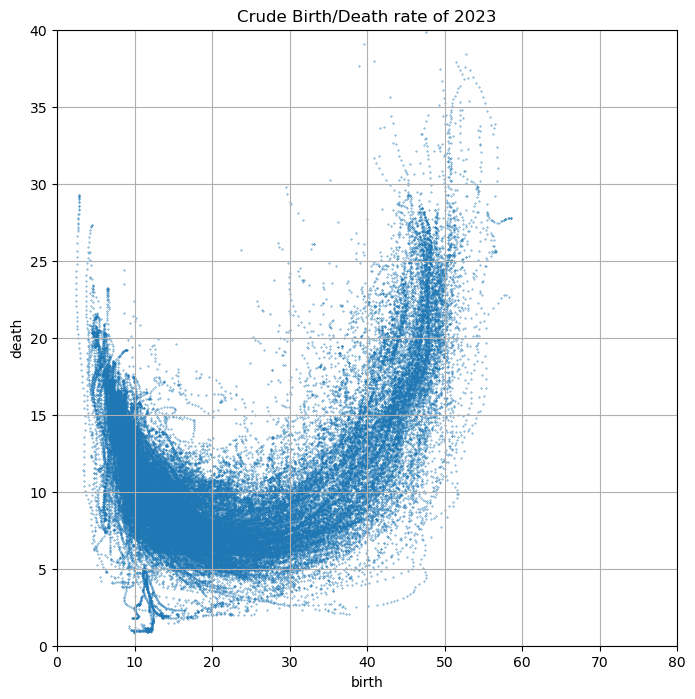

In [251]:
plt.figure(figsize=(8, 8))
plt.scatter(xs_data[:,0], xs_data[:,1], s = 0.1)
plt.grid(True)
plt.xlim(0,80)
plt.ylim(0,40)
plt.xlabel("birth")
plt.ylabel("death")
plt.title("Crude Birth/Death rate of 2023")
plt.show()

>**Question 6 :** On applique l'algorithme EM avec $m=3$. Comme observé ci-dessous, l'algorithme semble converger après une dizaine d'itérations. Les trois clusters obtenus épousent bien la forme de la distribution "banane" : dans la région de gauche ou les données sont denses, on observe un cluser étroit avec une probabilité d'apartenance de $0.35$ ; dans la région droite où les données sont plus étalées et sporadiques, on observe un large cluster avec probabilité $0.21$ ; enfin le dernier cluster couvre la partie inférieure de la banane avec une probabilité $0.43$.

In [252]:
n_iter = 100

# Initialisation at random with identity covs : 
key, subkey = jr.split(key)
subkey1, subkey2 = jr.split(subkey, 2)

alphas_0 = jr.uniform(subkey1, shape = (3,))
alphas_0 = alphas_0/jnp.sum(alphas_0)
means_0 = 50*jr.uniform(subkey2, shape = (3,2))
covs_0 = 50*jnp.array([jnp.eye(2)] * 3)


theta_init = {"alphas": alphas_0, "means": means_0, "covs": covs_0}
ll_init = log_likelihood(xs, alphas_0, means_0, covs_0)

theta, lls = em_GMM(xs_data, alphas_0, means_0, covs_0, n_iter)

=== Log-likelihood : === 

Initial log-likelihood : -20655.529296875
Final log-likelihood : -503934.96875

=== Parameters Estimation : === 

Estimated alphas : [0.4345996  0.21515696 0.35024342]



Estimated means : [[19.431742   7.8895984]
 [41.844555  15.5388365]
 [ 9.725773  11.864883 ]]



Estimated covariances : [[[40.041695  -2.3331316]
  [-2.3331316  4.084721 ]]

 [[33.16854   23.268433 ]
  [23.268433  38.508724 ]]

 [[ 4.7128983 -4.8983355]
  [-4.8983355  8.99007  ]]]


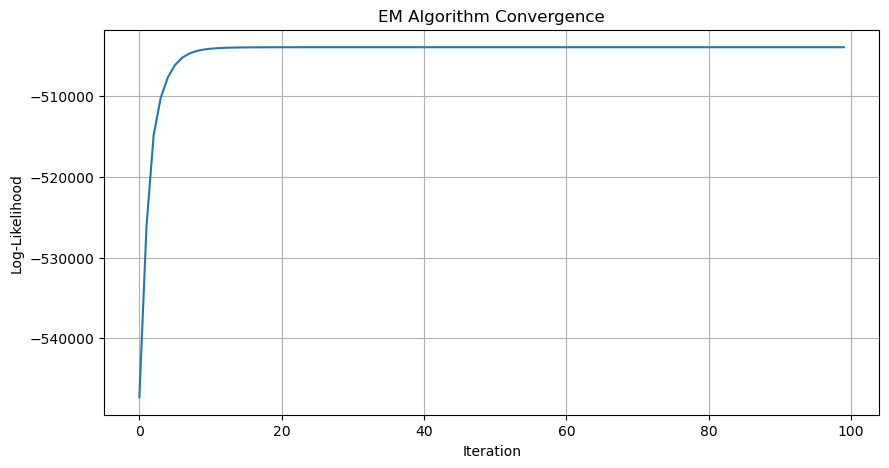

In [253]:
print("=== Log-likelihood : === \n")
print(f"Initial log-likelihood : {ll_init}")
print(f"Final log-likelihood : {lls[-1]}")

print("\n=== Parameters Estimation : === \n")
print(f"Estimated alphas : {theta["alphas"]}")
print("\n\n")

print(f"Estimated means : {theta["means"]}")
print("\n\n")

print(f"Estimated covariances : {theta["covs"]}")


plt.figure(figsize=(10, 5))
plt.plot(lls)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

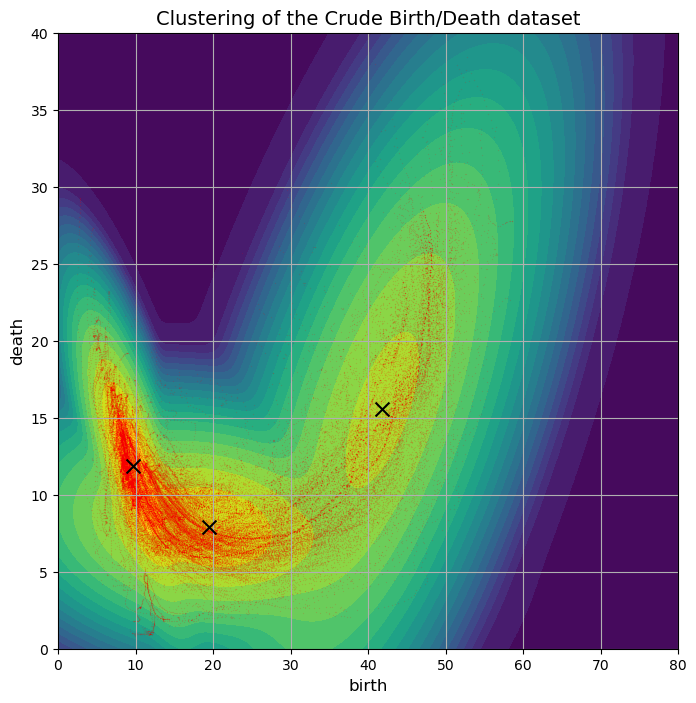

In [254]:
plot_gmm(xs_data, theta["alphas"], theta["means"],theta["covs"], title = "Clustering of the Crude Birth/Death dataset", xlabel = "birth", ylabel = "death", xlim = (0,80), ylim = (0,40), alpha = 0.1, s = 0.2)

>**Question 7 :** On utilise le critère de sélection de modèle BIC pour $m = 1, \dots, 50$. Dans notre cas le nombre de paramètres estimés $df(m)$ vaut $m + m \times d + m\times\frac{d(d+1)}{2}$ ($S_n^{++}(\mathbb{R})$ est une variété de dimension $\frac{d(d+1)}{2}$). On choisit donc 
\begin{equation}
    \hat m \in \arg \min -\log \mathcal{L}(x_1, \dots, x_n ; \theta) + \frac{\log(n)}{2}(m + m \times d + m\times\frac{d(d+1)}{2})
\end{equation}
La courbe produite indique que plus le $m$ est grand, meilleur est le modèle. Ce constat confirme que le modèle GMM ne semble pas adapté pour ce jeu de données. Le coude de la courbe semble se trouver autour de $m = 3$ qui constitue alors une bonne valeur pour notre jeu de donnée.

In [255]:
from tqdm import tqdm 

def BIC_fun(xs, m, key, n_iter=100): 
    n = xs.shape[0]
    d = xs.shape[1]

    # Initialize
    subkey1, subkey2 = jr.split(key)
    alphas_0 = jr.uniform(subkey1, shape = (m,))
    alphas_0 = alphas_0/jnp.sum(alphas_0)
    means_0 = 50*jr.uniform(subkey2, shape = (m,d))
    covs_0 = 50*jnp.array([jnp.eye(d)] * m)

    # Run the EM algo
    theta, lls = em_GMM(xs, alphas_0, means_0, covs_0, n_iter)

    # Compute the BIC
    return -lls[-1] + jnp.log(n)*(m+m*d+m*d*(d+1)/2)/2


ms = jnp.arange(1, 51)
key, subkey = jr.split(key)
subkeys = jr.split(subkey,10)
bics = []

for m in tqdm(range(1,51)):
    bics.append(BIC_fun(xs_data, m, subkeys[m-1]))

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


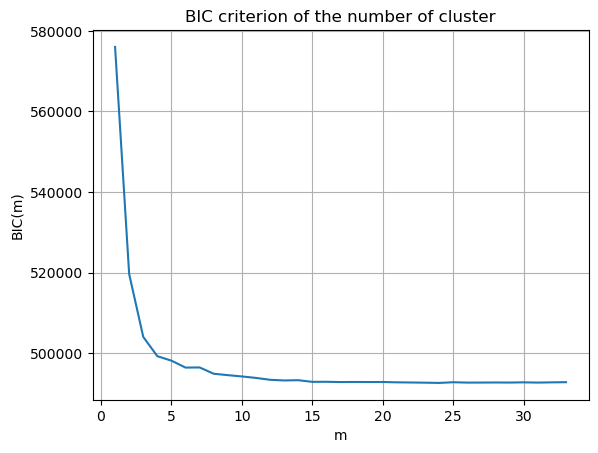

In [256]:
plt.plot(ms, bics)
plt.xlabel("m")
plt.ylabel("BIC(m)")
plt.title("BIC criterion of the number of cluster")
plt.grid(True)

## **Exercice 3 :**

### A. Poor Importance Sampling

>**Question 1 :** Remarquons que la condition $supp(p \times f) \subset supp(q)$ est vérifiée car $supp(q) = \mathbb{R}$. Par ailleurs, $p$ correspond à une densité [$\chi$](https://en.wikipedia.org/wiki/Chi_distribution) dont la constante de normalisation est $2^{k/2-1}\Gamma(k/2)$ et d'autre part, $q$ proportionnel à une loi normale, la constante de normalisation est $2$.

In [257]:
k = 1.65
mu = 0.8
sigma2 = 1.5

In [258]:
# chi distribution is not available in jax.scipy.chi
def chi_pdf(x, k):
    # pdf = (2^(1-k/2) / Gamma(k/2)) * x^(k-1) * exp(-x^2/2)
    log_pdf = (1-k/2)*jnp.log(2) + (k-1)*jnp.log(x)-x**2/2-gammaln(k/2)
    return jnp.where(x>0, jnp.exp(log_pdf),0.0)

In [259]:
f = lambda x : 2*jnp.sin(jnp.pi*x/1.5) # No need to put the idicator function as p is supported on R+

def importance_sampling(mu, key, N, maxN = 10000):
    # We use a maxN variable in order not to create an array of size N and use jax.vmap
    samples = mu + jnp.sqrt(sigma2) * jr.normal(key, shape=(maxN,))
    terms = jax.vmap(lambda x: f(x) * chi_pdf(x, k) / norm.pdf(x, mu, jnp.sqrt(sigma2)))(samples)
    mask = jnp.arange(maxN) < N
    return jnp.sum(jnp.where(mask, terms, 0.0)) / N

In [260]:
key, subkey = jr.split(key)
mean = importance_sampling(mu, subkey, 10000)
print(f"Mean value obtained by importance sampling : {mean}")

Mean value obtained by importance sampling : 0.7895513772964478


>**Question 2 :** On regarde l'évolution de la moyenne de notre estimateur lorsque l'on augmente le nombre d'échantillons utilisés dans la méthode d'importance sampling. On remarque que la variance de notre estimateur tends expodentiellement vers $0$. 

In [261]:
Ns = jnp.array([10, 100, 1000, 10000])
n_iteration = 10000 #Number of iteration to compute mean and variance of importance sampling
Ns_array = jnp.tile(Ns.reshape(-1, 1), (1, n_iteration))

key, subkey = jr.split(key)
subkeys2d = jr.split(subkey, 4 * n_iteration).reshape(4, n_iteration, 2)

# Apply importance sampling to n_iter times for all four values of N
results = jax.vmap(
    lambda key_vect, N_vect : jax.vmap(
        lambda key, N : importance_sampling(mu, key, N)
        )(key_vect, N_vect)
    )(subkeys2d, Ns_array)

means = jnp.mean(results, axis = 1)
vars = jnp.var(results, axis = 1)

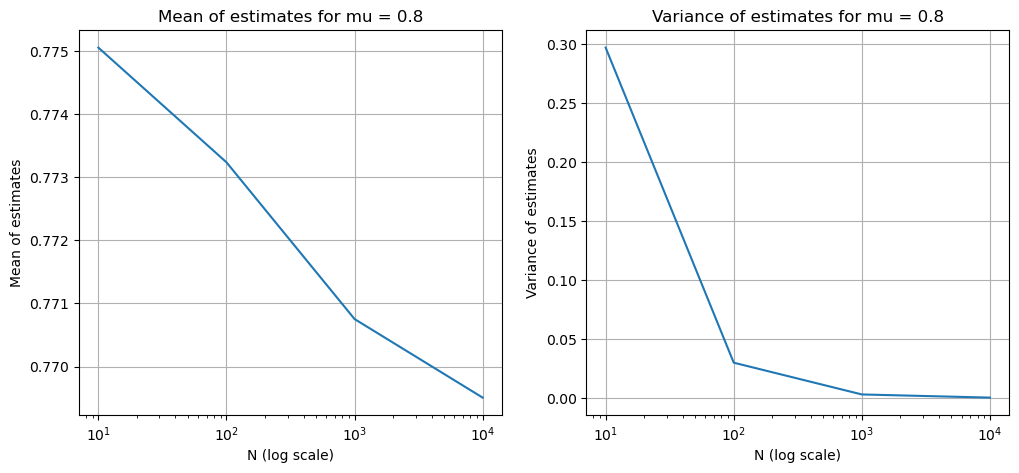

In [262]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(Ns, means)
ax[1].plot(Ns, vars)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("N (log scale)")
ax[0].set_ylabel("Mean of estimates")
ax[0].set_title(f"Mean of estimates for mu = {mu}")
ax[0].grid(True)
ax[1].set_xlabel("N (log scale)")
ax[1].set_ylabel("Variance of estimates")
ax[1].set_title(f"Variance of estimates for mu = {mu}")
ax[1].grid(True)

>**Question 3 :** On répète la même experience avec $\mu = 6$. On remarque alors que la de l'estimateur est bien plus importante, pour $N = 10^4$, on obtient une variance de $3 \times 10^{-4}$ pour la première valeur de $\mu$, contre $4$ pour la seconde. Par ailleurs, dans ce dernier cas, la variance ne semble même pas être une fonction décroissante du nombre d'échantillons.

In [263]:
mu2 = 6


Ns = jnp.array([10, 100, 1000, 10000])
n_iteration = 10000 #Number of iteration to compute mean and variance of importance sampling
Ns_array = jnp.tile(Ns.reshape(-1, 1), (1, n_iteration))

key, subkey = jr.split(key)
subkeys2d = jr.split(subkey, 4 * n_iteration).reshape(4, n_iteration, 2)

# Apply importance sampling to n_iter times for all four values of N
results2 = jax.vmap(
    lambda key_vect, N_vect : jax.vmap(
        lambda key, N : importance_sampling(mu2, key, N)
        )(key_vect, N_vect)
    )(subkeys2d, Ns_array)

means2 = jnp.mean(results2, axis = 1)
vars2 = jnp.var(results2, axis = 1)

Pour mu = 0.8, la variance finale vaut : 0.00029975740471854806
Pour mu = 6, la variance finale vaut : 3.906316041946411


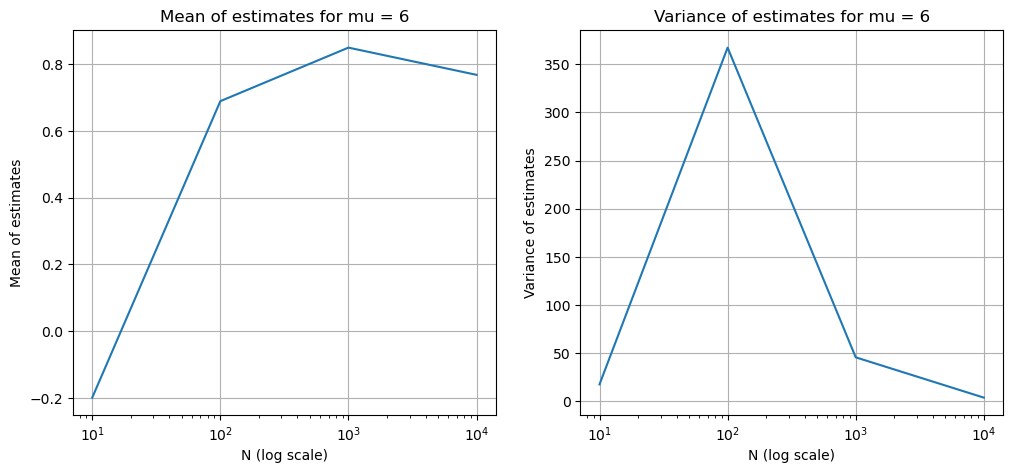

In [264]:
print(f"Pour mu = {mu}, la variance finale vaut : {vars[-1]}")
print(f"Pour mu = {mu2}, la variance finale vaut : {vars2[-1]}")


fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(Ns, means2)
ax[1].plot(Ns, vars2)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("N (log scale)")
ax[0].set_ylabel("Mean of estimates")
ax[0].set_title(f"Mean of estimates for mu = {mu2}")
ax[0].grid(True)
ax[1].set_xlabel("N (log scale)")
ax[1].set_ylabel("Variance of estimates")
ax[1].set_title(f"Variance of estimates for mu = {mu2}")
ax[1].grid(True)

### B. Adaptative Importance Sampling 

>**Question 4 :** L'étape $(iii)$ du Population Monte Carlo Algorithm consiste à résoudre le problème d'optimisation suivant : 
\begin{equation}
    \theta^* \in \arg \max_{\Theta} \sum_{i = 1}^n \tilde \omega_i \log\left(\sum_{j=1}^M\alpha_j \varphi(X_i; \theta_j)\right)
\end{equation}
En comparaison, l'algorithme EM étudié précédemment sert quand à lui à résoudre le problème d'optimisation suivant : 
\begin{equation}
    \theta^* \in \arg \max_{\Theta} \sum_{i = 1}^n \log\left(\sum_{j=1}^M\alpha_j \varphi(X_i; \theta_j)\right)
\end{equation}
Pour ce problème similaire, l'algorithme EM se traduit donc de la manière suivante :  
\begin{cases}
    \tilde Q(\theta, \theta^n) = \sum_{i = 1}^n \tilde \omega_i\mathbb{E}_{Z_i \sim p_{\theta^n}(\cdot |x_i)}[\log p_{\theta}(x_i,Z_i)] \\
    \theta^{n+1} \in \arg\max_{\theta\in \Theta} \tilde Q(\theta, \theta^n)
\end{cases}
On peut alors reprendre les dérivations de la question $3$ de l'exercice 2, à la différence que les poids $\tilde \omega_i$ sont en facteur des pondérations $\pi(j,x_i, \theta^n)$. Ainsi les rèlgles de mises à jour sont données par : 
\begin{align}
    &\alpha_j^{n+1} \gets \frac{1}{n}\sum_{i= 1}^n \tilde \omega_i\pi(j, x_i, \theta^n) \\
    &\mu_j^{n+1} \gets \frac{1}{\sum_{i=1}^n\tilde \omega_i\pi(j,x_i,\theta^n)}\sum_{i=1}^n\tilde \omega_i\pi(j,x_i,\theta^n)x_i \\
    &\Sigma_j^{n+1} \gets \frac{1}{\sum_{i=1}^n\tilde \omega_i\pi(j,x_i, \theta^n)}\sum_{i=1}^n\tilde \omega_i\pi(j,x_i, \theta^n)(x_i-\mu_j^{n+1})(x_i-\mu_j^{n+1})^T \\
\end{align}

### C. Application to a "banana"-shaped density

>**Question 5 :** On applique l'algorithme population Monte Carlo avec une étape d'optimisation EM, le tracé suivant montre bien une distribution avec forme de banane !

In [265]:
def log_nu(x):
    x_entry = x + 0.4*(x[0]**2-1)*jnp.array([0,1,0,0,0])
    return multivariate_normal.logpdf(x_entry, mean = jnp.zeros(5), cov = jnp.eye(5))


def log_mixture_density(x, alphas, means, covs):
    log_alphas = jnp.log(alphas)
    log_probs = jax.vmap(
        lambda log_alpha, mu, Sigma: log_alpha + multivariate_normal.logpdf(x, mu, Sigma)
    )(log_alphas, means, covs)
    return jax.scipy.special.logsumexp(log_probs)

In [266]:
# Same structure as the EM algorithm

def population_MC(alphas_0, means_0, covs_0, n_sample, n_iter, key):

    def pMC_step(carry, x):
        # Get carry
        alphas = carry["alphas"]
        means = carry["means"]
        covs = carry["covs"]
        key = carry["key"]

        # Sample from the current mixture of Gaussian
        key, subkey = jr.split(key)
        subkeys = jr.split(subkey, n_sample)
        xs = jax.vmap(lambda key : sample_GMM(alphas, means, covs, key))(subkeys)

        # Compute coefficient \tilde \omega_i
        # For numerical stability we use log-exp trick
        log_omegas = jax.vmap(lambda x : log_nu(x) - log_mixture_density(x, alphas, means, covs))(xs)
        log_sum_omega = jax.scipy.special.logsumexp(log_omegas)
        log_omegas_tilde = log_omegas - log_sum_omega + jnp.log(n_sample)
        log_omegas_tilde = log_omegas_tilde[:, None]


        # Compute \tilde \pi(j, x_i, \theta^n) = \tilde \omega_i \pi(j,x_i, \theta^n)
        log_alphas = jnp.log(alphas)
        log_probs = jax.vmap(
            lambda x: jax.vmap(
                lambda log_alpha, mu, Sigma: log_alpha + multivariate_normal.logpdf(x, mu, Sigma)
            )(log_alphas, means, covs)
        )(xs)
        log_norm = jax.scipy.special.logsumexp(log_probs, axis=1, keepdims=True)  # Shape: (n, 1)
        log_pi_tilde = log_probs - log_norm + log_omegas_tilde
        pi_tilde = jnp.exp(log_pi_tilde)


        # Update \theta
        alphas = jnp.sum(pi_tilde, axis = 0)/n_sample
        means = 1/(n_sample*alphas)[:,None]*jnp.dot(pi_tilde.T, xs)
        x_minus_mu = xs[:, None, :] - means[None, :, : ]
        right_member = x_minus_mu[:, :, :, None]@x_minus_mu[:, :, None, :]
        covs = 1/(n_sample*alphas)[:, None, None]*jnp.einsum('ij, ijkl -> jkl', pi_tilde, right_member)

        #Update the carry
        carry["alphas"] = alphas
        carry["means"] = means
        carry["covs"] = covs
        carry["key"] = key

        return carry, 0

    init = {"alphas": alphas_0, "means" : means_0, "covs" : covs_0, "key" : key}
    theta, _ = jax.lax.scan(pMC_step, init, jnp.zeros(n_iter)) # iterate the auxiliary step function
    theta.pop("key") # remove the key to return only GMM parameters
    return theta

In [267]:
key, subkey = jr.split(key)
subkey1, subkey2 = jr.split(subkey)

m = 3

alphas_0 = jnp.ones(m)/m
means_0 = jr.uniform(subkey, shape = (m,5))
covs_0 = jnp.array([jnp.eye(5)] * m)

theta = population_MC(alphas_0, means_0, covs_0, n_sample = 1000, n_iter = 200, key = subkey2)

In [268]:
key, subkey = jr.split(key)
subkeys = jr.split(subkey, 100000)
samples = jax.vmap(lambda key : sample_GMM(theta["alphas"], theta["means"], theta["covs"], key))(subkeys)

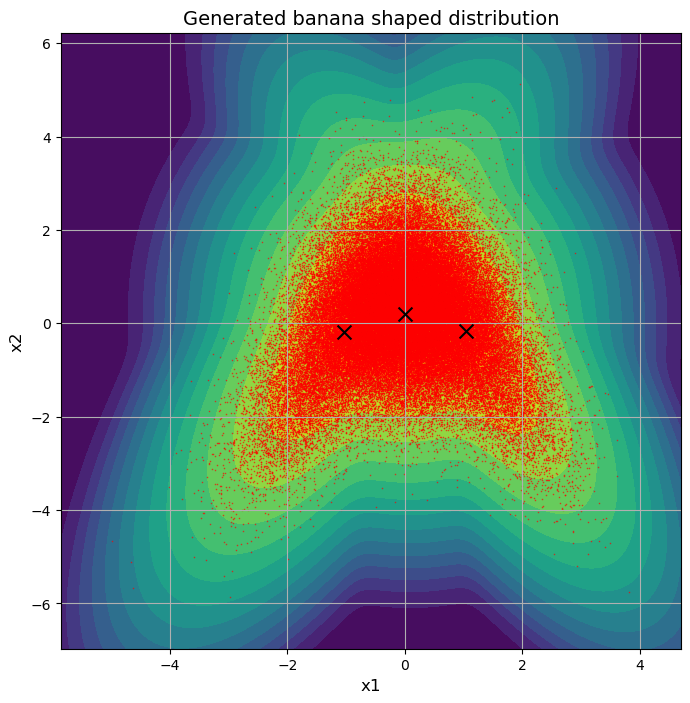

In [269]:
# Extract first 2 dimensions for plotting the banana shape
xs = samples[:,:2]
means_2d = theta["means"][:, :2]
covs_2d = theta["covs"][:, :2, :2]

plot_gmm(xs, theta["alphas"], means_2d, covs_2d, 
         title = "Generated banana shaped distribution", 
         xlabel = "x1", ylabel = "x2", s = 0.5)